# 2D Plane Strain FEA — scikit-fem

2D finite element analysis of the CCS bistable **half-beam** using `scikit-fem`.

**Approach**: Triangulate the half-beam polygon, apply plane strain elasticity with
geometrically nonlinear (Total Lagrangian) solver, sweep prescribed shuttle
displacement, extract reaction forces.

**Boundary conditions**:
- Anchor (x≈0): clamped, u_x = u_y = 0
- Shuttle (x≈L): prescribe u_y, u_x free

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

import triangle as tr
import skfem
from skfem import *
from skfem.models.elasticity import linear_elasticity, lame_parameters
from skfem.helpers import dot, ddot, sym_grad, transpose, eye, grad, det, inv

sys.path.insert(0, os.path.dirname(os.path.abspath("__file__")))
from beam_utils import (
    POLY_SI, DEFAULT_BEAM_PARAMS, get_beam_polygon,
    get_beam_centerline,
)

print(f"scikit-fem version: {skfem.__version__}")

# Parameters
L = DEFAULT_BEAM_PARAMS["half_span"]   # 20 µm
h = DEFAULT_BEAM_PARAMS["initial_offset"]  # 1.2 µm
t = POLY_SI["t"]
E = POLY_SI["E"]
nu = POLY_SI["nu"]
lam, mu = lame_parameters(E, nu)
print(f"Half-beam: L={L} µm, h={h} µm, t={t} µm")
print(f"Lamé: λ={lam:.1f}, μ={mu:.1f} MPa")

scikit-fem version: 12.0.1
Half-beam: L=20.0 µm, h=1.2 µm, t=0.5 µm
Lamé: λ=51522.2, μ=65573.8 MPa


## 1. Mesh Generation from Beam Polygon

In [2]:
# Get half-beam polygon (closed, Nx2)
poly = get_beam_polygon(n_points=600)

# Remove closing point for triangle (it wants open polyline with segment list)
if np.allclose(poly[0], poly[-1]):
    poly = poly[:-1]

n_verts = len(poly)
segments = np.column_stack([np.arange(n_verts), (np.arange(n_verts) + 1) % n_verts])

tri_input = {'vertices': poly, 'segments': segments}

# Triangulate with quality constraints
max_area = 0.005  # µm²
tri_out = tr.triangulate(tri_input, f'pq30a{max_area}')

nodes = tri_out['vertices']
elems = tri_out['triangles']
print(f"Mesh: {len(nodes)} nodes, {len(elems)} triangles")

Mesh: 4227 nodes, 7237 triangles


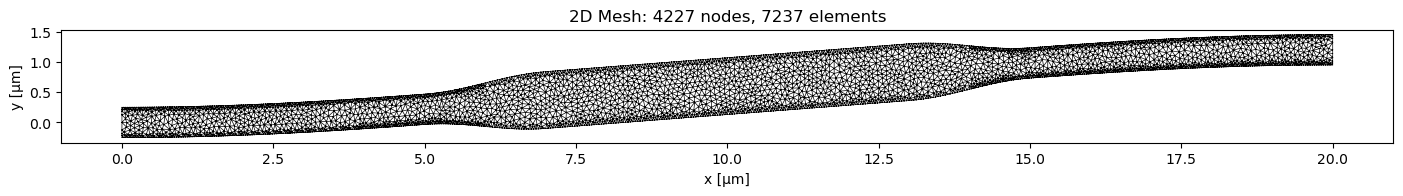

In [3]:
# Create scikit-fem mesh with explicit dtypes to avoid silent truncation
mesh = MeshTri(
    np.ascontiguousarray(nodes.T, dtype=np.float64),
    np.ascontiguousarray(elems.T, dtype=np.int64),
)
assert mesh.nvertices == len(nodes), f"Expected {len(nodes)} vertices, got {mesh.nvertices}"
assert mesh.nelements == len(elems), f"Expected {len(elems)} elements, got {mesh.nelements}"

# Visualize mesh
fig, ax = plt.subplots(figsize=(14, 4))
mesh.draw(ax=ax)
ax.set_aspect('equal')
ax.set_title(f'2D Mesh: {mesh.nvertices} nodes, {mesh.nelements} elements')
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')

fig.tight_layout()
fig.savefig('plots/skfem_2d_mesh.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. Identify Boundary Nodes

Half-beam BCs:
- Anchor (x≈0): clamp u_x = u_y = 0
- Shuttle (x≈L): prescribe u_y, leave u_x free

Anchor nodes: 14
Shuttle nodes: 14


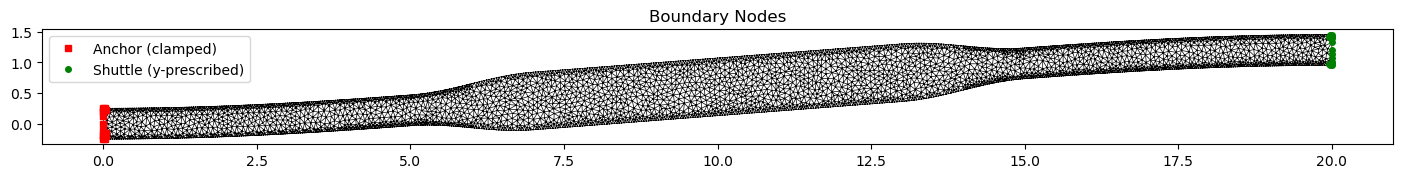

In [4]:
tol = 0.05  # µm tolerance

# Anchor nodes (x ≈ 0): fully clamped
anchor_nodes = np.where(mesh.p[0] < tol)[0]

# Shuttle nodes (x ≈ L): prescribe y-displacement
shuttle_nodes = np.where(mesh.p[0] > L - tol)[0]

print(f"Anchor nodes: {len(anchor_nodes)}")
print(f"Shuttle nodes: {len(shuttle_nodes)}")

# Visualize
fig, ax = plt.subplots(figsize=(14, 4))
mesh.draw(ax=ax)
ax.plot(mesh.p[0, anchor_nodes], mesh.p[1, anchor_nodes], 'rs', ms=4, label='Anchor (clamped)')
ax.plot(mesh.p[0, shuttle_nodes], mesh.p[1, shuttle_nodes], 'go', ms=4, label='Shuttle (y-prescribed)')
ax.legend()
ax.set_aspect('equal')
ax.set_title('Boundary Nodes')
fig.tight_layout()
plt.show()

## 3. Linear Elasticity Sweep

Quick validation with linear elastic solver to verify mesh and BCs.
Uses P1 elements (linear triangles) for robust DOF handling.

In [5]:
# Use P1 (linear) elements — robust and sufficient for this mesh density
elem = ElementTriP1()
ib = Basis(mesh, ElementVector(elem))

# In scikit-fem v12, Nbfun is per-element DOFs (6 for vector P1 tri).
# Total system DOFs = 2 * nvertices for P1 vector elements.
N = mesh.nvertices
ndofs_total = 2 * N
print(f"Per-element DOFs: {ib.Nbfun}")
print(f"System DOFs: {ndofs_total} ({N} vertices)")

# Assemble linear elastic stiffness
K = linear_elasticity(lam, mu).assemble(ib)
assert K.shape[0] == ndofs_total, f"K size {K.shape[0]} != expected {ndofs_total}"
print(f"Stiffness matrix: {K.shape[0]}×{K.shape[1]}")

# DOF layout for ElementVector(P1) is INTERLEAVED: [x0, y0, x1, y1, ...]
# Node i: x-component = DOF 2*i, y-component = DOF 2*i+1
anchor_x_dofs = 2 * anchor_nodes
anchor_y_dofs = 2 * anchor_nodes + 1
fixed_dofs = np.concatenate([anchor_x_dofs, anchor_y_dofs])

# Shuttle: prescribe y only (x is free)
shuttle_y_dofs = 2 * shuttle_nodes + 1

print(f"Fixed DOFs (anchor): {len(fixed_dofs)}")
print(f"Prescribed DOFs (shuttle y): {len(shuttle_y_dofs)}")

Per-element DOFs: 6
System DOFs: 8454 (4227 vertices)
Stiffness matrix: 8454×8454
Fixed DOFs (anchor): 28
Prescribed DOFs (shuttle y): 14


In [6]:
# Linear displacement sweep: push shuttle from y=h to y=-h
n_disp_steps = 100
delta_vals = np.linspace(0, -2 * h, n_disp_steps)  # displacement from initial
F_linear = np.zeros(n_disp_steps)

all_constrained = np.concatenate([fixed_dofs, shuttle_y_dofs])

for i, delta in enumerate(delta_vals):
    # Full-size prescribed displacement vector
    x_pre = np.zeros(ndofs_total)
    x_pre[shuttle_y_dofs] = delta  # anchor DOFs stay at 0

    u = solve(*condense(K, np.zeros(ndofs_total), D=all_constrained, x=x_pre))

    f_react = K @ u
    F_linear[i] = np.sum(f_react[shuttle_y_dofs])

print(f"Linear sweep done. F range: [{F_linear.min():.4f}, {F_linear.max():.4f}] µN")

Linear sweep done. F range: [-5.3015, 0.0000] µN


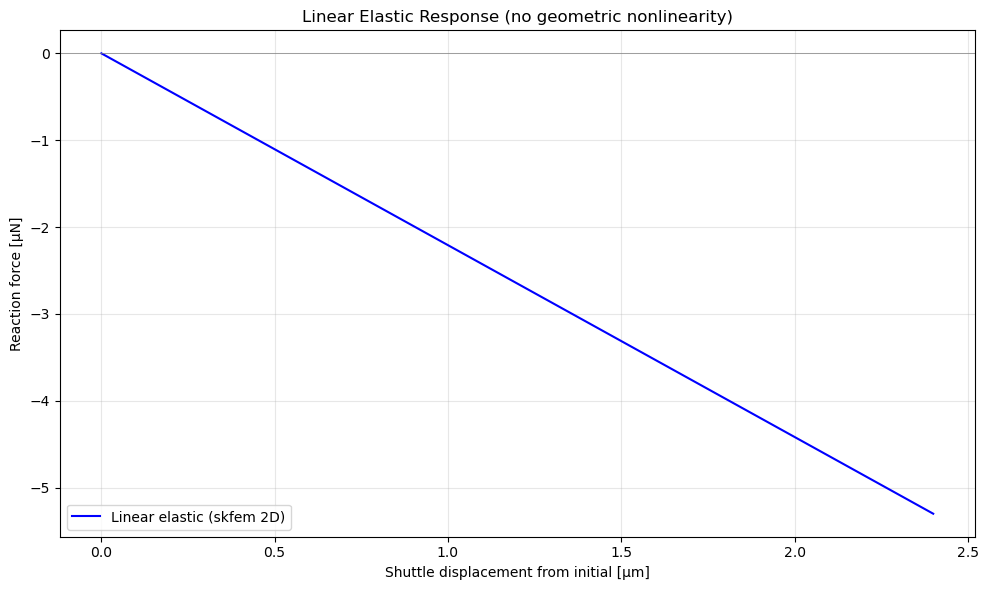

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(-delta_vals, F_linear, 'b-', linewidth=1.5, label='Linear elastic (skfem 2D)')
ax.axhline(0, color='gray', linewidth=0.5)
ax.set_xlabel('Shuttle displacement from initial [µm]')
ax.set_ylabel('Reaction force [µN]')
ax.set_title('Linear Elastic Response (no geometric nonlinearity)')
ax.legend()
ax.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()

## 4. Geometrically Nonlinear Solver (Total Lagrangian)

For large deformations (snap-through), we need geometric nonlinearity.
We use a Total Lagrangian formulation with Green-Lagrange strain
and 2nd Piola-Kirchhoff stress.

Newton-Raphson iteration at each displacement step.

In [8]:
from skfem.assembly import BilinearForm, LinearForm

# Identity matrix that broadcasts with (2, 2, nqp, nel) tensor fields
I2 = np.eye(2).reshape(2, 2, 1, 1)

def mat(A, B):
    """Matrix-matrix product for (2,2,...) tensor fields."""
    return np.einsum('ij...,jk...->ik...', A, B)

@BilinearForm
def stiffness_nl(u, v, w):
    """Tangent stiffness for Total Lagrangian with St. Venant-Kirchhoff material."""
    du = grad(w['prev'])
    F = I2 + du
    # Green-Lagrange strain: E = 0.5*(F^T F - I)
    GL = 0.5 * (mat(transpose(F), F) - I2)
    trE = GL[0, 0] + GL[1, 1]
    S = lam * trE * I2 + 2.0 * mu * GL

    dv = grad(v)
    dw = grad(u)

    # Linearized GL strain
    dGL = 0.5 * (mat(transpose(F), dw) + mat(transpose(dw), F))
    trDE = dGL[0, 0] + dGL[1, 1]
    dS = lam * trDE * I2 + 2.0 * mu * dGL
    dGL_v = 0.5 * (mat(transpose(F), dv) + mat(transpose(dv), F))

    k_mat = ddot(dS, dGL_v)
    k_geo = ddot(S, 0.5 * (mat(transpose(dw), dv) + mat(transpose(dv), dw)))
    return k_mat + k_geo


@LinearForm
def internal_forces(v, w):
    """Internal force vector (residual) for Total Lagrangian."""
    du = grad(w['prev'])
    F = I2 + du
    GL = 0.5 * (mat(transpose(F), F) - I2)
    trE = GL[0, 0] + GL[1, 1]
    S = lam * trE * I2 + 2.0 * mu * GL
    dv = grad(v)
    dGL_v = 0.5 * (mat(transpose(F), dv) + mat(transpose(dv), F))
    return ddot(S, dGL_v)

print("Nonlinear forms defined.")

Nonlinear forms defined.


In [9]:
# Nonlinear displacement sweep with Newton-Raphson
n_nl_steps = 200
delta_nl = np.linspace(0, -2*h, n_nl_steps)
F_nl = np.zeros(n_nl_steps)

u_current = np.zeros(ndofs_total)
max_newton = 50
nl_tol = 1e-8

all_bc = np.concatenate([fixed_dofs, shuttle_y_dofs])

for i, delta in enumerate(delta_nl):
    u_target = u_current.copy()
    u_target[fixed_dofs] = 0.0
    u_target[shuttle_y_dofs] = delta

    u_iter = u_target.copy()
    converged = False

    for newton_iter in range(max_newton):
        u_field = ib.interpolate(u_iter)
        Kt = stiffness_nl.assemble(ib, prev=u_field)
        fint = internal_forces.assemble(ib, prev=u_field)

        residual = fint.copy()
        residual[all_bc] = 0.0
        res_norm = np.linalg.norm(residual)

        if res_norm < nl_tol:
            converged = True
            break

        du_corr = solve(*condense(Kt, -residual, D=all_bc))
        u_iter += du_corr

    if not converged and i > 0:
        print(f"  Step {i}: δ={delta:.4f}, not converged (res={res_norm:.2e})")

    u_current = u_iter.copy()

    u_field = ib.interpolate(u_current)
    fint = internal_forces.assemble(ib, prev=u_field)
    F_nl[i] = np.sum(fint[shuttle_y_dofs])

    if i % 50 == 0:
        print(f"  Step {i}/{n_nl_steps}: δ={delta:.3f} µm, F={F_nl[i]:.4f} µN")

print("Nonlinear sweep complete.")

  Step 0/200: δ=0.000 µm, F=0.0000 µN
  Step 50/200: δ=-0.603 µm, F=-1.3272 µN
  Step 100/200: δ=-1.206 µm, F=-2.6510 µN
  Step 150/200: δ=-1.809 µm, F=-3.9806 µN
Nonlinear sweep complete.


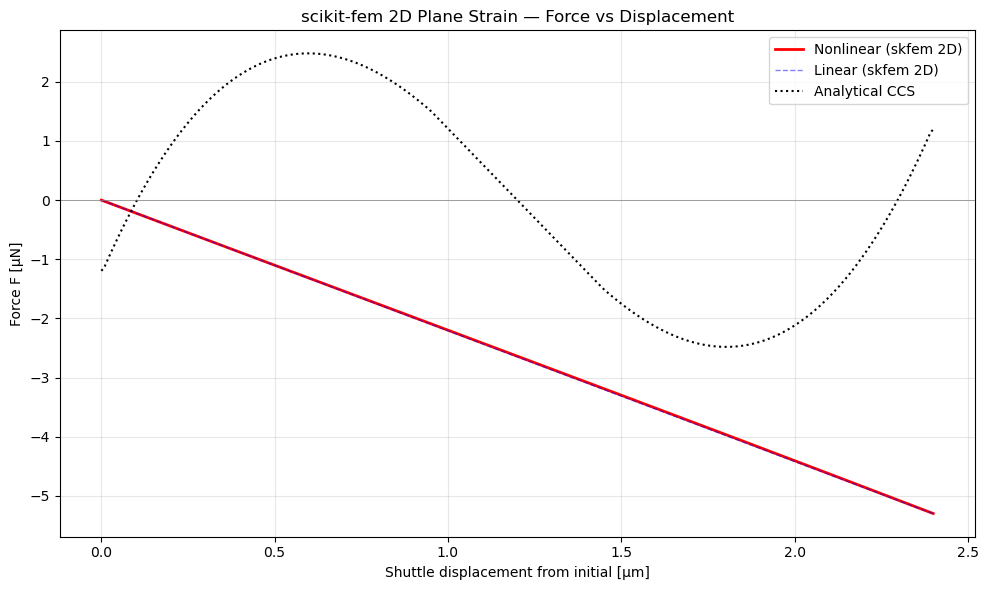

In [10]:
# Plot nonlinear force-displacement
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(-delta_nl, F_nl, 'r-', linewidth=2, label='Nonlinear (skfem 2D)')
ax.plot(-delta_vals, F_linear, 'b--', linewidth=1, alpha=0.5, label='Linear (skfem 2D)')

# Load analytical for comparison
try:
    ana_data = np.loadtxt('results/analytical_force_displacement.csv',
                          delimiter=',', skiprows=1)
    ax.plot(ana_data[:, 0], ana_data[:, 2], 'k:', linewidth=1.5,
            label='Analytical CCS')
except FileNotFoundError:
    print("(Analytical results not yet available for overlay)")

ax.axhline(0, color='gray', linewidth=0.5)
ax.set_xlabel('Shuttle displacement from initial [µm]')
ax.set_ylabel('Force F [µN]')
ax.set_title('scikit-fem 2D Plane Strain — Force vs Displacement')
ax.legend()
ax.grid(True, alpha=0.3)

fig.tight_layout()
fig.savefig('plots/skfem_2d_force_displacement.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Deformed Shapes

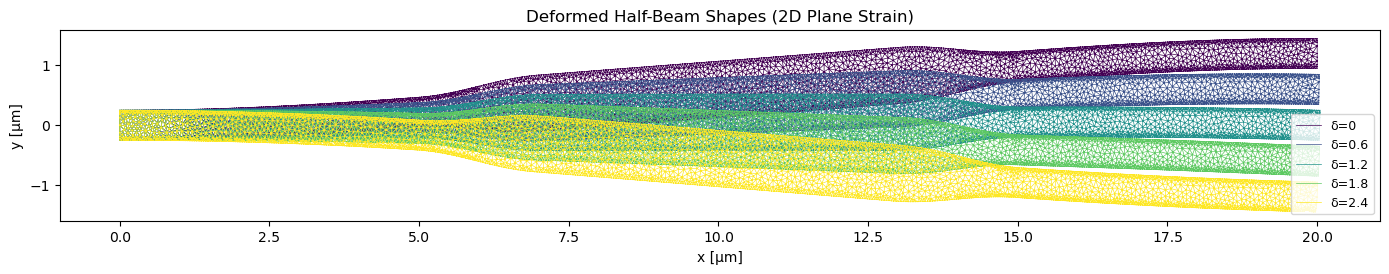

In [11]:
# Deformed shapes at key displacements
key_deltas = [0.0, -h/2, -h, -1.5*h, -2*h]
key_labels = ['δ=0', f'δ={h/2:.1f}', f'δ={h:.1f}', f'δ={1.5*h:.1f}', f'δ={2*h:.1f}']

fig, ax = plt.subplots(figsize=(14, 6))
ax.triplot(mesh.p[0], mesh.p[1], mesh.t.T, 'k-', alpha=0.1, linewidth=0.3)

colors = plt.cm.viridis(np.linspace(0, 1, len(key_deltas)))

for k, (delta, label) in enumerate(zip(key_deltas, key_labels)):
    u_vis = np.zeros(ndofs_total)
    u_vis[shuttle_y_dofs] = delta

    for _ in range(max_newton):
        u_field = ib.interpolate(u_vis)
        Kt = stiffness_nl.assemble(ib, prev=u_field)
        fint = internal_forces.assemble(ib, prev=u_field)
        residual = fint.copy()
        residual[all_bc] = 0.0
        if np.linalg.norm(residual) < nl_tol:
            break
        du_c = solve(*condense(Kt, -residual, D=all_bc))
        u_vis += du_c

    # Interleaved DOF layout: x0,y0,x1,y1,...
    ux = u_vis[0::2]
    uy = u_vis[1::2]
    ax.triplot(mesh.p[0] + ux, mesh.p[1] + uy, mesh.t.T,
               '-', color=colors[k], linewidth=0.5, label=label)

ax.set_aspect('equal')
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')
ax.set_title('Deformed Half-Beam Shapes (2D Plane Strain)')
ax.legend(fontsize=9)

fig.tight_layout()
fig.savefig('plots/skfem_2d_deformed_shapes.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Von Mises Stress at Snap-Through

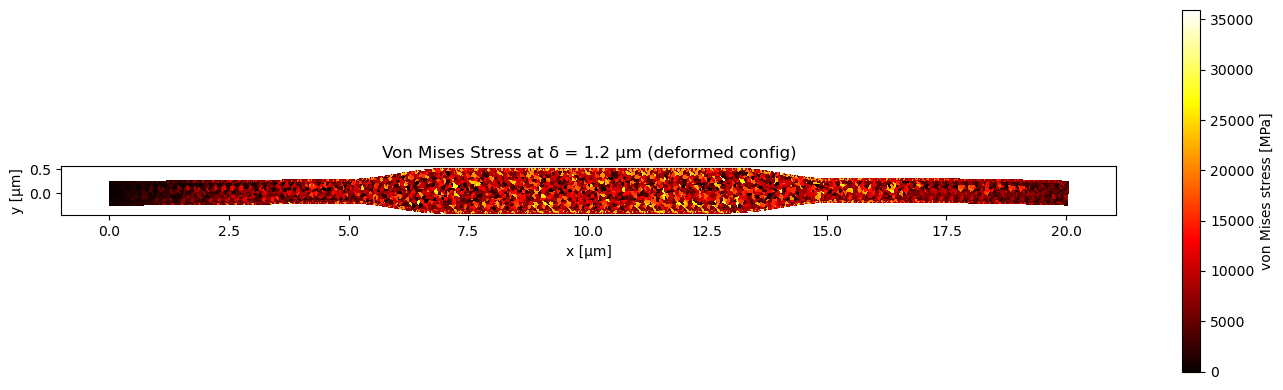

Max von Mises stress: 35940.5 MPa


In [12]:
# Compute stress at snap-through displacement
delta_snap_approx = -h  # approximate snap-through point

u_snap = np.zeros(ndofs_total)
u_snap[shuttle_y_dofs] = delta_snap_approx

for _ in range(max_newton):
    u_field = ib.interpolate(u_snap)
    Kt = stiffness_nl.assemble(ib, prev=u_field)
    fint = internal_forces.assemble(ib, prev=u_field)
    residual = fint.copy()
    residual[all_bc] = 0.0
    if np.linalg.norm(residual) < nl_tol:
        break
    du_c = solve(*condense(Kt, -residual, D=all_bc))
    u_snap += du_c

# Per-element von Mises stress from vertex displacements
# Interleaved DOF layout: x0,y0,x1,y1,...
ux_v = u_snap[0::2]
uy_v = u_snap[1::2]

vm_elem = np.zeros(mesh.nelements)
for ei in range(mesh.nelements):
    ni = mesh.t[:, ei]
    x_e = mesh.p[0, ni]
    y_e = mesh.p[1, ni]
    ux_e = ux_v[ni]
    uy_e = uy_v[ni]

    # Shape function derivatives for linear triangle
    J = np.array([[x_e[1]-x_e[0], x_e[2]-x_e[0]],
                  [y_e[1]-y_e[0], y_e[2]-y_e[0]]])
    detJ = np.linalg.det(J)
    if abs(detJ) < 1e-15:
        continue
    Jinv = np.linalg.inv(J)
    dNdx = Jinv @ np.array([[-1, 1, 0], [-1, 0, 1]])

    # Displacement gradient
    dudx = np.dot(ux_e, dNdx[0])
    dudy = np.dot(ux_e, dNdx[1])
    dvdx = np.dot(uy_e, dNdx[0])
    dvdy = np.dot(uy_e, dNdx[1])

    H = np.array([[dudx, dudy], [dvdx, dvdy]])
    F_def = np.eye(2) + H
    GL = 0.5 * (F_def.T @ F_def - np.eye(2))

    trE = GL[0, 0] + GL[1, 1]
    S_pk = lam * trE * np.eye(2) + 2.0 * mu * GL
    s11, s22, s12 = S_pk[0, 0], S_pk[1, 1], S_pk[0, 1]
    s33 = lam * trE
    vm_elem[ei] = np.sqrt(0.5 * ((s11-s22)**2 + (s22-s33)**2 + (s33-s11)**2 + 6*s12**2))

# Plot
fig, ax = plt.subplots(figsize=(14, 4))
tpc = ax.tripcolor(mesh.p[0] + ux_v, mesh.p[1] + uy_v, mesh.t.T,
                    facecolors=vm_elem, cmap='hot')
fig.colorbar(tpc, ax=ax, label='von Mises stress [MPa]')
ax.set_aspect('equal')
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')
ax.set_title(f'Von Mises Stress at δ = {abs(delta_snap_approx):.1f} µm (deformed config)')

fig.tight_layout()
fig.savefig('plots/skfem_2d_stress_contour.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Max von Mises stress: {vm_elem.max():.1f} MPa")

## 7. Save Results

In [13]:
np.savetxt('results/skfem_2d_force_displacement.csv',
           np.column_stack([-delta_nl, F_nl]),
           delimiter=',',
           header='delta_um,F_uN',
           comments='')

print("Saved: results/skfem_2d_force_displacement.csv")
print(f"\nForce range: [{F_nl.min():.4f}, {F_nl.max():.4f}] µN")

Saved: results/skfem_2d_force_displacement.csv

Force range: [-5.2984, 0.0000] µN
